# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox



In [3]:
one_track_id = track_df['track.id'].unique()[2]
one_track = track_df[track_df['track.id'] == one_track_id]
one_track

,id,time,geometry,Calculated MAF.value,Calculated MAF.unit,Intake Pressure.value,Intake Pressure.unit,CO2.value,CO2.unit,Intake Temperature.value,...,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eb7582165b80c5d6be6a144,2020-05-09T08:12:25,POINT (7.65306 51.97227),10.880032,g/s,60.000000,kPa,8.404792,kg/h,43.000001,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eb7582165b80c5d6be6a146,2020-05-09T08:12:30,POINT (7.65311 51.97235),6.341226,g/s,49.000000,kPa,4.898577,kg/h,42.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eb7582165b80c5d6be6a147,2020-05-09T08:12:35,POINT (7.65294 51.97243),9.548188,g/s,59.821840,kPa,7.375946,kg/h,42.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eb7582165b80c5d6be6a148,2020-05-09T08:12:40,POINT (7.65250 51.97243),10.059148,g/s,48.740000,kPa,7.770661,kg/h,43.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eb7582165b80c5d6be6a149,2020-05-09T08:12:45,POINT (7.65211 51.97231),13.122590,g/s,58.386473,kPa,10.137161,kg/h,42.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,5eb7582165b80c5d6be6a1ae,2020-05-09T08:21:15,POINT (7.65199 51.95401),4.979614,g/s,40.000000,kPa,3.846736,kg/h,33.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,5eb7582165b80c5d6be6a1af,2020-05-09T08:21:20,POINT (7.65183 51.95399),4.872397,g/s,41.000000,kPa,3.763912,kg/h,34.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,5eb7582165b80c5d6be6a1b0,2020-05-09T08:21:25,POINT (7.65180 51.95398),4.773719,g/s,41.000000,kPa,3.687683,kg/h,34.999999,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,5eb7582165b80c5d6be6a1b1,2020-05-09T08:21:30,POINT (7.65180 51.95398),4.893662,g/s,41.000000,kPa,3.780339,kg/h,35.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add elevation

In [4]:
import requests as req,json
url='https://api.opentopodata.org/v1/eudem25m?locations='
def generate_parms(s,e):
    lats= list(one_track[s:e]['geometry'].y)
    lngs = list(one_track[s:e]['geometry'].x)
    track_coords = [c for c in zip(lats, lngs)]
    format_str=list(map(lambda x : str(x[0])+','+str(x[1])+'|', track_coords)) 
    concat_str = ''.join(format_str)
    return concat_str

def request(link):
    elevation = req.request('GET',link)
    results = elevation.json()['results']
    h = list(map(lambda x : x['elevation'], results))
    return h
# estimate the len of data
batch = [int(len(one_track)/100),len(one_track)%100]
elevation=[]
# get elevation 
for i in range(batch[0]+1):
    #create requeest 100 parameter 
    s = i*100,
    e = (i+1)*100
    if i<batch[0]+1:
        --e 
    else:
        e= e+batch[1]
    parms=generate_parms(s,e)
    access=url+parms
    part = request(access)
    elevation.extend(part)
one_track['elevation']=elevation

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


KeyError: 'results'

## Calculate gradient(Elevation) & add time interval

In [5]:
def distance(lon1,lon2,lat1,lat2):
    R = 6370000 #radius
    φ1=lat1 * np.pi /180
    φ2 = lat2 * np.pi /180
    Δφ = (lat2-lat1) * np.pi /180
    Δλ = (lon2-lon1) * np.pi /180
    a = np.sin(Δφ/2) * np.sin(Δφ/2) +np.cos(φ1) * np.cos(φ2) *np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a));
    return R * c
def gradient(height,distance):
    return np.arctan(height/distance) * 180/np.pi

for i in one_track.index:
    if (i == len(one_track)-1):
        break
    lat1= one_track.loc[i,'geometry'].y
    lat2= one_track.loc[i+1,'geometry'].y
    lon1= one_track.loc[i,'geometry'].x
    lon2= one_track.loc[i+1,'geometry'].x
    heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
    one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
    
    one_track.loc[i,'gradient']= gradient(heightdiff,one_track.loc[i+1,'seg_distance'])

## Add interval time
j = 5
for i in one_track.index:
    one_track.loc[i, 'time_interval'] = j
    j = j+5

# Convert the speed unit to m/s
for i in one_track.index:
    one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] * 0.27777

## Getting the velocity equation & Calculate the acceleration

In [258]:

## get the speed equation
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed'])
idx = np.isfinite(time_interval) & np.isfinite(speed)

def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

speed_equation = get_equation(time_interval[idx], speed[idx])

    
## calculate the acceleration using the derivative

for i in one_track.index:
    if one_track.loc[i, 'speed'] == 0:
        one_track.loc[i, 'Acceleration'] = 0
    else:
        one_track.loc[i, 'Acceleration'] = derivative(speed_equation, one_track.loc[i, 'time_interval'])




## Filter the data

In [283]:
realistc_drive = one_track[['speed', 'time', 'time_interval', 'Acceleration', 'gradient']]


## Define General Parameters 

In [267]:
P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

##  Define Parameters for vehicle

In [268]:
# m = mass of the car  "kg" 
# A = cross-sectional of the car "m²"
# Cw = Air drag cofficient 
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Define fuel consumption

In [269]:
def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

## Define engine power (KW)
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance)
        return [power/1000]
    else:
        return [P_idle,0]

## Engine Power

In [279]:
## Calculates Engine Power for general car
for i in realistc_drive.index:
    ep = engine_power(car,0.02,realistc_drive.gradient[i],realistc_drive.speed[i],realistc_drive.Acceleration[i])
    if ep[0] < 0:
        realistc_drive.loc[i, 'engine_power'] = P_idle
    else:
        realistc_drive.loc[i, 'engine_power'] = ep[0]
        
#Calculates Engine Power for Volks
for i in realistc_drive.index:
    ep = engine_power(volks,0.02,realistc_drive.gradient[i],realistc_drive.speed[i],realistc_drive.Acceleration[i])
    if ep[0] < 0:
        realistc_drive.loc[i, 'eng_pw_volks'] = P_idle
    else:
        realistc_drive.loc[i, 'eng_pw_volks'] = ep[0]
    
    

## Estimate Fuel Consumption / CO2 Emissions

In [281]:
## Fuel consumption for General car (gasoline)
for i in realistc_drive.index:
    car_cons = fuel_consumption(realistc_drive.engine_power[i],H_g, efc) 
    realistc_drive.loc[i, 'Consumption Gasoline'] = car_cons   ## liters / hour
    realistc_drive.loc[i, 'CO2 Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
## Fuel consumption for for Volks (diesel)
for i in realistc_drive.index:
    volks_cons = fuel_consumption(realistc_drive.eng_pw_volks[i],H_d, efc) 
    realistc_drive.loc[i, 'Consumption volks diesel'] = volks_cons    ## liters / hour
    realistc_drive.loc[i, 'CO2 volks diesel'] = volks_cons * 2.69     ## kg Co2 / hour



In [282]:
realistc_drive

,speed,time,time_interval,Acceleration,gradient,engine_power,eng_pw_volks,Consumption Gasoline,CO2 Gasoline,Consumption volks diesel,CO2 volks diesel
0,0.000000,2020-05-09T08:12:25,5.0,0.000000,0.350112,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
1,2.685165,2020-05-09T08:12:30,10.0,0.282066,-0.772110,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
2,4.301243,2020-05-09T08:12:35,15.0,0.290838,-0.640602,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
3,5.910192,2020-05-09T08:12:40,20.0,0.340835,-0.073303,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
4,5.676346,2020-05-09T08:12:45,25.0,0.258978,-0.111005,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
...,...,...,...,...,...,...,...,...,...,...,...
105,2.993958,2020-05-09T08:21:15,530.0,-0.266485,0.507774,21.004372,21.985691,7.956201,19.015321,7.402590,19.912966
106,1.292451,2020-05-09T08:21:20,535.0,-0.350577,0.422776,7.471131,7.819873,2.829974,6.763637,2.632954,7.082646
107,0.000000,2020-05-09T08:21:25,540.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
108,0.000000,2020-05-09T08:21:30,545.0,0.000000,0.008992,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448


## Import OSM Network, in the same area of tracks

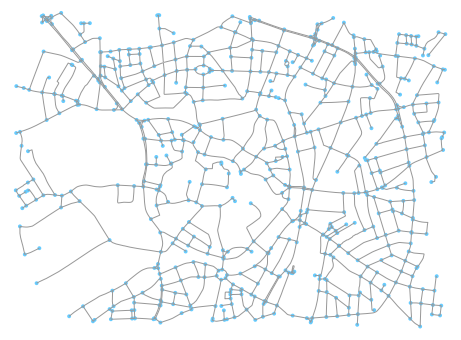

(<Figure size 576.497x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e4776655c8>)

In [243]:
import osmnx as ox

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

## Convert the OSM Netwok to geodataframe and filter the attributes

In [260]:
nodes, streets = ox.graph_to_gdfs(G)
road_network = streets[['maxspeed','length','surface']]
road_network
#to check the type of surface "for rolling coff."
for i in road_network.index:
    if road_network.loc[i, 'surface'] == "asphalt":
        road_network.loc[i, 'rolling_resistance'] = 0.02 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "cobblestone":
        road_network.loc[i, 'rolling_resistance'] = 0.015 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "paving_stones":
        road_network.loc[i, 'rolling_resistance'] = 0.033 # source: The Automotive Chassis book
    else:
        road_network.loc[i, 'rolling_resistance'] = 0.02
        
road_network

,maxspeed,length,surface,rolling_resistance
0,50,6.146,asphalt,0.02
1,50,200.247,asphalt,0.02
2,30,12.933,asphalt,0.02
3,50,96.147,asphalt,0.02
4,NaN,119.161,asphalt,0.02
...,...,...,...,...
915,30,68.594,asphalt,0.02
916,30,56.319,asphalt,0.02
917,NaN,56.935,NaN,0.02
918,30,81.071,asphalt,0.02


# Retrieve the Location of the Route

In [6]:
a=one_track['geometry']  #conveys location info about the route 
print(a)

0      POINT (7.65306 51.97227)
1      POINT (7.65311 51.97235)
2      POINT (7.65294 51.97243)
3      POINT (7.65250 51.97243)
4      POINT (7.65211 51.97231)
                 ...           
105    POINT (7.65199 51.95401)
106    POINT (7.65183 51.95399)
107    POINT (7.65180 51.95398)
108    POINT (7.65180 51.95398)
109    POINT (7.65180 51.95398)
Name: geometry, Length: 110, dtype: geometry


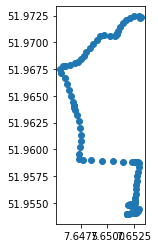

In [7]:
a.plot() #plotting the route 

In [8]:
import folium
lats = list(one_track['geometry'].apply(lambda coord: coord.y))
lngs = list(one_track['geometry'].apply(lambda coord: coord.x))
avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
m = folium.Map(location=[avg_lat, avg_lngs], zoom_start=13)
folium.PolyLine([coords for coords in zip(lats, lngs)], color='blue').add_to(m)
m 
#plotting the route in the map for reference

## Add elevation to all the points

In [9]:
import requests as req
import time
url = 'https://api.opentopodata.org/v1/eudem25m?locations='    #retrieve elevation data from opentopodata.org
def get_elvdata(lat,lng):
    access = url+str(lat)+(',')+str(lng)
    elevation = req.request('GET',access)
    data = eval(elevation.text)
    print(data) # debug code for everyone to check the request status
    return data['results'][0]['elevation']
for i in one_track.index:     
    one_track.loc[i,'elevation'] = get_elvdata(one_track.loc[i,'geometry'].y,one_track.loc[i,'geometry'].x)   #adding elevation data in the table
    time.sleep(1) 
elev_list= []
  
try:
    for i in range(len(one_track)):
        elev_list.append(get_elvdata(one_track[i],one_track[i]))
        time.sleep(1)
except Exception as err:
    print(str(err))
#giving 1 second time to retrieve data from server for all the elevation data      
print(elev_list)

one_track

{'results': [{'elevation': 59.10440444946289, 'location': {'lat': 51.972273546271026, 'lng': 7.653064001351595}}], 'status': 'OK'}


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


{'results': [{'elevation': 59.1578369140625, 'location': {'lat': 51.972347160838794, 'lng': 7.653108948898172}}], 'status': 'OK'}
{'results': [{'elevation': 58.96221160888672, 'location': {'lat': 51.97242707033375, 'lng': 7.652941338383542}}], 'status': 'OK'}
{'results': [{'elevation': 58.62269592285156, 'location': {'lat': 51.97243434596708, 'lng': 7.65249814269891}}], 'status': 'OK'}
{'results': [{'elevation': 58.584041595458984, 'location': {'lat': 51.97230765126906, 'lng': 7.652107879570824}}], 'status': 'OK'}
{'results': [{'elevation': 58.5159912109375, 'location': {'lat': 51.97206739101269, 'lng': 7.651774863501147}}], 'status': 'OK'}
{'results': [{'elevation': 58.49385452270508, 'location': {'lat': 51.97175901895436, 'lng': 7.651426092815025}}], 'status': 'OK'}
{'results': [{'elevation': 59.04962158203125, 'location': {'lat': 51.97140097769112, 'lng': 7.6511878029417115}}], 'status': 'OK'}
{'results': [{'elevation': 59.73016357421875, 'location': {'lat': 51.97109148913613, 'lng'

,id,time,geometry,Calculated MAF.value,Calculated MAF.unit,Intake Pressure.value,Intake Pressure.unit,CO2.value,CO2.unit,Intake Temperature.value,...,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,elevation,seg_distance,gradient,time_interval,speed
0,5eb7582165b80c5d6be6a144,2020-05-09T08:12:25,POINT (7.65306 51.97227),10.880032,g/s,60.000000,kPa,8.404792,kg/h,43.000001,...,NaN,NaN,NaN,NaN,NaN,59.104404,NaN,0.350112,5.0,0.000000
1,5eb7582165b80c5d6be6a146,2020-05-09T08:12:30,POINT (7.65311 51.97235),6.341226,g/s,49.000000,kPa,4.898577,kg/h,42.999999,...,NaN,NaN,NaN,NaN,NaN,59.157837,8.744105,-0.772110,10.0,2.685165
2,5eb7582165b80c5d6be6a147,2020-05-09T08:12:35,POINT (7.65294 51.97243),9.548188,g/s,59.821840,kPa,7.375946,kg/h,42.999999,...,NaN,NaN,NaN,NaN,NaN,58.962212,14.515844,-0.640602,15.0,4.301243
3,5eb7582165b80c5d6be6a148,2020-05-09T08:12:40,POINT (7.65250 51.97243),10.059148,g/s,48.740000,kPa,7.770661,kg/h,43.000000,...,NaN,NaN,NaN,NaN,NaN,58.622696,30.365175,-0.073303,20.0,5.910192
4,5eb7582165b80c5d6be6a149,2020-05-09T08:12:45,POINT (7.65211 51.97231),13.122590,g/s,58.386473,kPa,10.137161,kg/h,42.999999,...,NaN,NaN,NaN,NaN,NaN,58.584042,30.213382,-0.111005,25.0,5.676346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,5eb7582165b80c5d6be6a1ae,2020-05-09T08:21:15,POINT (7.65199 51.95401),4.979614,g/s,40.000000,kPa,3.846736,kg/h,33.999999,...,NaN,NaN,NaN,NaN,NaN,62.591785,16.408955,NaN,530.0,2.993958
106,5eb7582165b80c5d6be6a1af,2020-05-09T08:21:20,POINT (7.65183 51.95399),4.872397,g/s,41.000000,kPa,3.763912,kg/h,34.999999,...,NaN,NaN,NaN,NaN,NaN,62.690655,11.155850,NaN,535.0,1.292451
107,5eb7582165b80c5d6be6a1b0,2020-05-09T08:21:25,POINT (7.65180 51.95398),4.773719,g/s,41.000000,kPa,3.687683,kg/h,34.999999,...,NaN,NaN,NaN,NaN,NaN,62.706928,2.205391,NaN,540.0,0.000000
108,5eb7582165b80c5d6be6a1b1,2020-05-09T08:21:30,POINT (7.65180 51.95398),4.893662,g/s,41.000000,kPa,3.780339,kg/h,35.000000,...,NaN,NaN,NaN,NaN,NaN,62.706928,0.001688,NaN,545.0,0.000000


# Elevation profile of the route

In [10]:
import urllib.request
import json
import math
import matplotlib.pyplot as plt

#defining start end points
P1=[51.97227,7.65306]  
P2=[51.95398,7.65180]  

#number of points
s=100
interval_lat=(P2[0]-P1[0])/s #interval for latitude
interval_lon=(P2[1]-P1[1])/s #interval for longitude

#set a new variable for start point
lat0=P1[0]
lon0=P1[1]

#latitude and longitude list
lat_list=[lat0]
lon_list=[lon0]

#generating points
for i in range(s):
    lat_step=lat0+interval_lat
    lon_step=lon0+interval_lon
    lon0=lon_step
    lat0=lat_step
    lat_list.append(lat_step)
    lon_list.append(lon_step)

#haversine function
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad=np.radians(lat1)
    lat2_rad=np.radians(lat2)
    lon1_rad=np.radians(lon1)
    lon2_rad=np.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=np.sqrt((np.sin(delta_lat/2))**2+np.cos(lat1_rad)*np.cos(lat2_rad)*(np.sin(delta_lon/2))**2)
    d=2*6371000*np.arcsin(a)
    return d   
     

In [11]:
#distance calculation
d_list=[]
for j in range(len(lat_list)):
    lat_p=lat_list[j]
    lon_p=lon_list[j]
    dp=haversine(lat0,lon0,lat_p,lon_p)/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1] #reverse list


#constructing json
d_ar=[{}]*len(lat_list)
for i in range(len(lat_list)):
    d_ar[i]={"latitude":lat_list[i],"longitude":lon_list[i]}
location={"locations":d_ar}
json_data=json.dumps(location,skipkeys=int).encode('utf8')
print(json_data)
import requests as req

url = 'https://api.opentopodata.org/v1/eudem25m?locations='   #retrieve elevation data from opentopodata.org
def get_elvdata(lat,lng):
    access = url+str(lat)+(',')+str(lng)
    elevation = req.request('GET',access)
    data = eval(elevation.text)
    print(data)
    return data['results'][0]['elevation']
elev_list= []

#send request 

import time

    
try:
    for i in range(len(lat_list)):
        elev_list.append(get_elvdata(lat_list[i],lon_list[i]))       
        time.sleep(1)
except Exception as err:
    print(str(err))
#giving 1 second time to retrieve data from server for all the elevation data    
print(elev_list)

    

b'{"locations": [{"latitude": 51.97227, "longitude": 7.65306}, {"latitude": 51.9720871, "longitude": 7.6530474}, {"latitude": 51.971904200000004, "longitude": 7.6530348}, {"latitude": 51.971721300000006, "longitude": 7.6530222000000006}, {"latitude": 51.97153840000001, "longitude": 7.653009600000001}, {"latitude": 51.97135550000001, "longitude": 7.652997000000001}, {"latitude": 51.97117260000001, "longitude": 7.652984400000001}, {"latitude": 51.97098970000001, "longitude": 7.652971800000001}, {"latitude": 51.97080680000001, "longitude": 7.6529592000000015}, {"latitude": 51.970623900000014, "longitude": 7.652946600000002}, {"latitude": 51.970441000000015, "longitude": 7.652934000000002}, {"latitude": 51.97025810000002, "longitude": 7.652921400000002}, {"latitude": 51.97007520000002, "longitude": 7.652908800000002}, {"latitude": 51.96989230000002, "longitude": 7.6528962000000025}, {"latitude": 51.96970940000002, "longitude": 7.652883600000003}, {"latitude": 51.96952650000002, "longitude"

In [12]:
#basic statistics information
mean_elev=round((sum(elev_list)/len(elev_list)),3)
min_elev=min(elev_list)
max_elev=max(elev_list)
distance=d_list_rev[-1] 

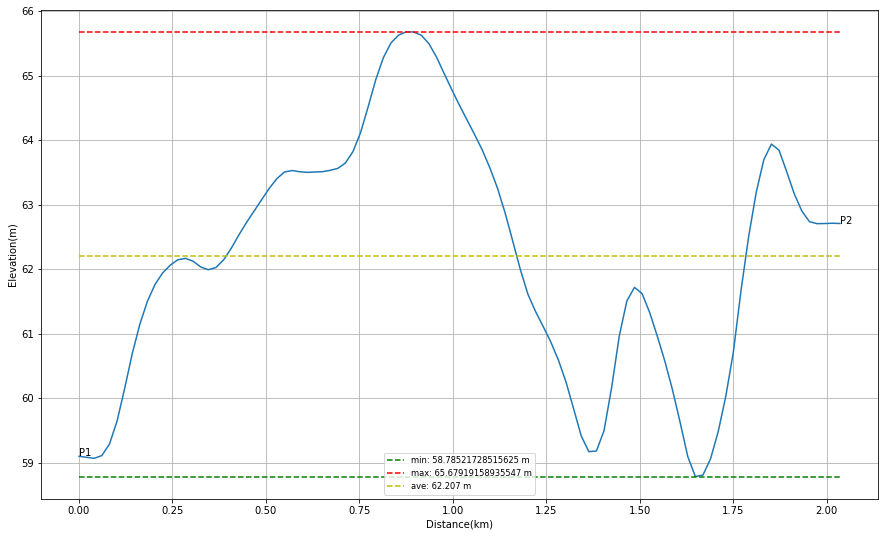

In [24]:
 #plot elevation profile with min, max and average elevation 
base_reg=0
plt.figure(figsize=(15,9))
plt.plot(d_list_rev,elev_list)
plt.plot([0,distance],[min_elev,min_elev],'--g',label='min: '+str(min_elev)+' m')
plt.plot([0,distance],[max_elev,max_elev],'--r',label='max: '+str(max_elev)+' m')
plt.plot([0,distance],[mean_elev,mean_elev],'--y',label='ave: '+str(mean_elev)+' m')
#plt.fill_between(d_list_rev,elev_list,base_reg,alpha=0.1)
plt.text(d_list_rev[0],elev_list[0],"P1")
plt.text(d_list_rev[-1],elev_list[-1],"P2")
plt.xlabel("Distance(km)")
plt.ylabel("Elevation(m)")
plt.grid()
plt.legend(fontsize='small')
plt.show()